# Ubicación de polos

In [220]:
import numpy as np
import control as co
import control.matlab as com
import math as mt
import matplotlib.pyplot as plt

# TP
R1 = 2.2e3
C1 = 1e-6
R2 = 1e2
C2 = 1e-6

Ts = 1e-3

A = np.array([[-(1/R1+1/R2)/C1, 1/(R2*C1)], [1/(R2*C2), -1/(R2*C2)]])
B = np.array([[1/(R1*C1)], [0]])
C = np.array([[0, 1]])
sys = co.ss(A, B,C,0)

p1o,p2o = co.poles(sys)

In [221]:
# Define a function to calculate the rise time
def calculate_rise_time(signal, time,ref_value=1):
    # Find the index where the signal first crosses the start threshold
    start_index = np.argmax(signal >= 0.1*ref_value)
    
    # Find the index where the signal crosses the end threshold
    end_index = np.argmax(signal >= 0.9*ref_value)
    
    # Calculate the rise time as the difference between the two indices, multiplied by the time step
    rise_time = time[end_index] - time[start_index]
    
    return rise_time

In [222]:
p1 = -10*abs(p1o)
p2 = -11*abs(p2o)


p1d = mt.exp(p1*Ts)
p2d = mt.exp(p2*Ts)

In [223]:
# Compute the state-space representation of the system

sysd = com.c2d(sys,Ts)

# Compute the feedback gain using pole placement
L = co.place(sysd.A, sysd.B, [p1d, p2d])

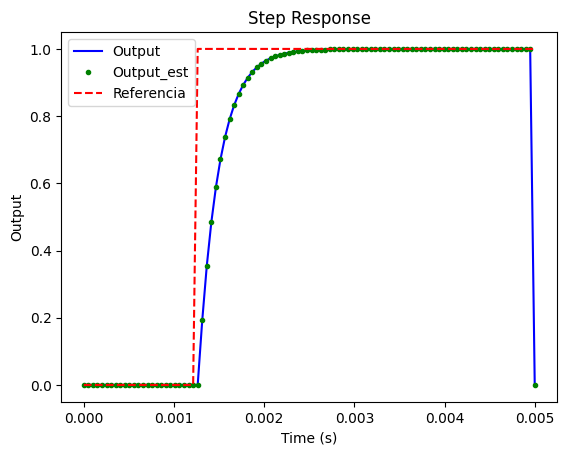

In [224]:
t = np.linspace(0, 5*Ts, 100)
u = np.append(np.zeros(int(len(t)/4)), np.ones(int(len(t)*3/4)))
n = len(sysd.A)

x = np.zeros((len(sysd.A),len(t))).reshape((n, len(t)))
x_est = np.zeros((len(sysd.A),len(t)))
y = np.zeros(len(t))
y_est = np.zeros(len(t))
x_est[:,1] = [0.01,-0.02]

for i in range(len(t)-1):
    x[:, i+1:i+2] = np.matmul(sysd.A,x[:, i:i+1]) + sysd.B*u[i]
    y[i] = np.matmul(sysd.C,x[:, i])
    
    x_est[:, i+1:i+2] = np.matmul(sysd.A,x_est[:, i:i+1]) + sysd.B*u[i] + L[0,0]*(y[i]-np.matmul(sysd.C, x_est[:, i]))
    y_est[i] = np.matmul(sysd.C,x_est[:, i])

plt.plot(t, y, 'b-', label='Output')
plt.plot(t, y_est, 'g.', label='Output_est')
plt.plot(t,u, 'r--', label='Referencia')
plt.legend(loc='best')
plt.title('Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.show()

## Realimentación de estados con observador

### Opción 1: Dividir la entrada por la ganancia en estado estacionario

Ganancia K:  [[-5.3518125   5.47959087]]
Ganancia K0:  [[1.12777838]]


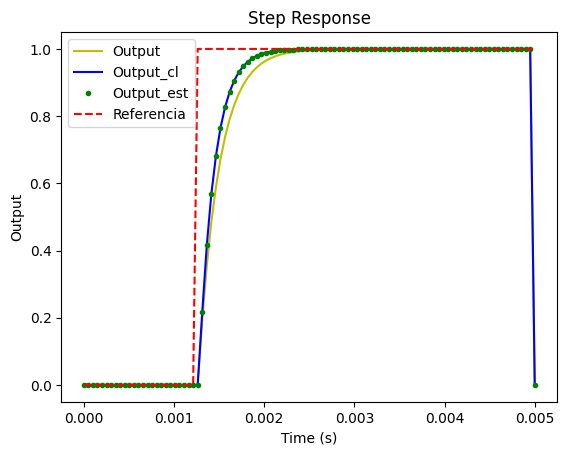

In [229]:
p1 = 1.35*abs(p1o)
p2 = 1.35*abs(p2o)

p1d = mt.exp(p1*Ts)
p2d = mt.exp(p2*Ts)

# print(" A: ",sysd.A)
# print(" B: ",sysd.B)
# print(" C ",sysd.C)
# print(" L: ",L[0,0])

# Compute the feedback gain using pole placement
K = co.place(sysd.A, sysd.B, [p1d, p2d])/1.0e+13
print("Ganancia K: ",K)

sysdlc = co.ss(sysd.A-sysd.B*K,sysd.B,sysd.C,sysd.D)
g = sysdlc.C*(np.eye(2)-sysdlc.A)**(-1)*sysdlc.B
K0 = 1/g

print("Ganancia K0: ",K0)

x_cl = np.zeros((len(sysd.A),len(t)))
y_cl = np.zeros(len(t))
r = np.append(np.zeros(int(len(t)/4)), np.ones(int(len(t)*3/4)))
u = np.zeros(len(t))

for i in range(len(t)-1):
    u[i] = K0*r[i]-np.matmul(K, x_est[:, i])

    x_cl[:, i+1:i+2] = np.matmul(sysd.A,x_cl[:, i:i+1]) + sysd.B*u[i]
    y_cl[i] = np.matmul(sysd.C,x_cl[:, i])
    
    x_est[:, i+1:i+2] = np.matmul(sysd.A,x_est[:, i:i+1]) + sysd.B*u[i] + L[0,0]*(y_cl[i]-np.matmul(sysd.C, x_est[:, i]))
    y_est[i] = np.matmul(sysd.C,x_est[:, i])
    

plt.plot(t, y, 'y-', label='Output')
plt.plot(t, y_cl, 'b-', label='Output_cl')
plt.plot(t, y_est, 'g.', label='Output_est')
plt.plot(t,r, 'r--', label='Referencia')
plt.legend(loc='best')
plt.title('Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.show()

In [226]:
t_r = calculate_rise_time(y,t)
print('Tiempo de subida en LA:',t_r)
print('Tiempo de subida deseado:',0.7*t_r)

Tiempo de subida en LA: 0.000505050505050505
Tiempo de subida deseado: 0.00035353535353535354


In [227]:
tr_lc = calculate_rise_time(y_cl,t)
print('Tiempo de subida en LC:',tr_lc)
t_dif = 100*(tr_lc-t_r)/t_r
print("Mejora en el tiempo se subida: ",t_dif)

Tiempo de subida en LC: 0.0003535353535353534
Mejora en el tiempo se subida:  -30.00000000000002
